In [1]:
import os, sys
import numpy as np
import EMdata

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools

In [3]:
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time
from numpy.random import multinomial

# Loading Data

In [4]:
#GPU or CPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 

In [220]:
#data path
file_path='F:/script/class2vec/real_star_file/simulation/NoNoise_sameori.star'
datatype=1 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [221]:
# parameters
#window size
#w = 4

#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44] #GSS20173_300
#ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46] 
#ignore_classes=[14] #10243_tau
#ignore_classes=[2,3,4,11,12,19,20,25,33,36,37,40,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig
#ignore_classes=[2,3,4,11,12,13,19,20,25,33,36,37,40,42,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig by observe
#ignore_classes=[2,5,6,7,12,16,19,23,24,25,30,31,32,33,39,44,45,50] #10340_Case2_tau_ig_E8
#ignore_classes=[]

In [222]:
if datatype<2:
    file_info=EMdata.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=EMdata.process_cryosparc_helical(dataset).extract_helical()
corpus_dic,helix_name=corpus_information
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]
print('convert done')

['_rlnImageName', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginX', '_rlnOriginY', '_rlnHelicalTubeID', '_rlnGroupNumber', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples']
['000001@Noise/NoNoise_same_ori/type1.mrcs', '-90.00000', '90.000000', '85.902787', '-3.72839', '-10.72839', '1', '1', '1', '0.251522', '1.248239e+05', '0.972804', '3']
finish reading
finish converting
[( 1,   1,   0) (18,   2,   1) (18,   3,   2) (18,   4,   3)
 (18,   5,   4) (10,   6,   5) (10,   7,   6) (10,   8,   7)
 (10,   9,   8) (10,  10,   9) ( 1,  11,  10) ( 1,  12,  11)
 ( 1,  13,  12) (17,  14,  13) (17,  15,  14) (17,  16,  15)
 (10,  17,  16) (10,  18,  17) (10,  19,  18) (10,  20,  19)
 (10,  21,  20) (10,  22,  21) ( 5,  23,  22) ( 5,  24,  23)
 ( 5,  25,  24) (14,  26,  25) (14,  27,  26) (14,  28,  27)
 (14,  29,  28) (14,  30,  29) (17,  31,  30) (17,  32,  31)
 (17,  33,  32) (17,  34,  33) (17,  35, 

In [223]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    lst=corpus[i]
    count=lst[0][1]
    for j in range(len(lst)):
        particle=lst[j]
        if count==int(particle[1]):
            corpus_row.append(particle[0])
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(particle[0])
                    count+=1
                    break
                corpus_row+=[0]
                count+=1               
    corpus_ignore.append(corpus_row)

In [224]:
print(len(helix_name))

100


In [225]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
fig,ax=plt.subplots(2)
ax[0].hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,1)))
ax[1].bar(list(range(0,len(corpus_backup))),corpus_length_histogram)
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"length_histogram.png",bbox_inches='tight', pad_inches=0.01)

<BarContainer object of 100 artists>

# Pre-processing

In [226]:
#k-mer seperation
def overlaping_kmer(data,k):
    kmer_corpus=[]
    for i in range(len(data)):
        lst=data[i]
        kmer_lst=[]
        for j in range(len(lst)-k+1):
            kmer_lst.append(str(lst[j])+'-'+str(lst[j+1]))
        kmer_corpus.append(kmer_lst)
    return kmer_corpus

In [227]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [228]:
#corpus=overlaping_kmer(corpus_backup,2)
#corpus_context=corpus[:]

In [229]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

13


In [230]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [231]:
#corpus=cut_corpus(corpus_backup,60)
#corpus_context=corpus_backup[:]

In [232]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus_ignore))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [233]:
# convert to windoes vector
w = 1
context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus_ignore:
    for i, word in enumerate(text):
        if word==0:
            print(type(word))
            continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            neighbor=text[j]
            if j==0:
                continue
            if neighbor==0:
                continue
            if i!=j:
                context_tuple_list.append((word, neighbor, next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 12035 pairs of target and context words


# Word2vec

In [234]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [235]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [236]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [237]:
embedding_size=100
#loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)
n=0
while True:
    n=n+1
    print(n)
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=1000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)),torch.stack(losses)[0],torch.stack(losses)[-1])
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break
    if torch.mean(torch.stack(losses))<10:
        break

1
Loss:  tensor(11851.8418, device='cuda:0') tensor(14552.8936, device='cuda:0') tensor(413.2307, device='cuda:0')
2
Loss:  tensor(10235.3008, device='cuda:0') tensor(11523.1836, device='cuda:0') tensor(320.2033, device='cuda:0')
Loss gain: 13.63957691192627%
3
Loss:  tensor(8797.9873, device='cuda:0') tensor(9995.5947, device='cuda:0') tensor(345.0959, device='cuda:0')
Loss gain: 25.766918182373047%
4
Loss:  tensor(7501.7925, device='cuda:0') tensor(8939.8564, device='cuda:0') tensor(278.3717, device='cuda:0')
Loss gain: 36.70357131958008%
5
Loss:  tensor(6370.6909, device='cuda:0') tensor(7081.0532, device='cuda:0') tensor(265.6124, device='cuda:0')
Loss gain: 46.247249603271484%
6
Loss:  tensor(5452.7070, device='cuda:0') tensor(6113.5708, device='cuda:0') tensor(273.5299, device='cuda:0')
Loss gain: 46.72645950317383%
7
Loss:  tensor(4705.5962, device='cuda:0') tensor(5660.6416, device='cuda:0') tensor(156.5689, device='cuda:0')
Loss gain: 46.51508331298828%
8
Loss:  tensor(4056.68

Loss:  tensor(235.7430, device='cuda:0') tensor(256.0610, device='cuda:0') tensor(15.0102, device='cuda:0')
Loss gain: 2.7528364658355713%
61
Loss:  tensor(234.3631, device='cuda:0') tensor(274.2318, device='cuda:0') tensor(4.7115, device='cuda:0')
Loss gain: 2.6359670162200928%
62
Loss:  tensor(232.8930, device='cuda:0') tensor(262.9178, device='cuda:0') tensor(14.6261, device='cuda:0')
Loss gain: 2.5187759399414062%
63
Loss:  tensor(231.5549, device='cuda:0') tensor(232.6454, device='cuda:0') tensor(11.5643, device='cuda:0')
Loss gain: 2.4325599670410156%
64
Loss:  tensor(230.4007, device='cuda:0') tensor(288.8282, device='cuda:0') tensor(16.9445, device='cuda:0')
Loss gain: 2.2661545276641846%
65
Loss:  tensor(229.0032, device='cuda:0') tensor(279.0140, device='cuda:0') tensor(9.2798, device='cuda:0')
Loss gain: 2.287010431289673%
66
Loss:  tensor(228.0700, device='cuda:0') tensor(235.2713, device='cuda:0') tensor(12.0845, device='cuda:0')
Loss gain: 2.0709068775177%
67
Loss:  tenso

In [238]:
print(context_tuple_list[0])

(8, 8, [9, 19, 8, 8])


# Show 2D class embedding

In [239]:
import umap

In [240]:
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.metrics import pairwise_distances

EMBEDDINGS.shape:  (13, 100)
1


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


2
3
4
5


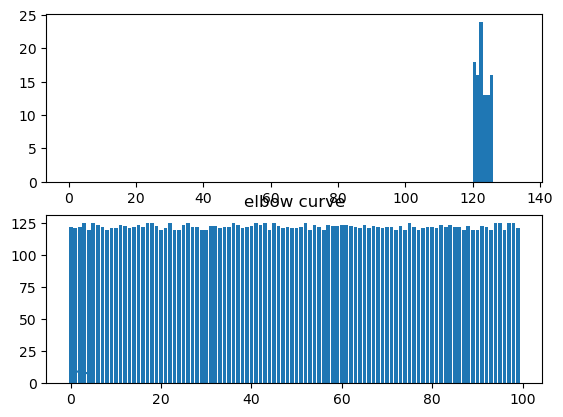

In [241]:
EMBEDDINGS = net.target.weight.data.cpu().numpy()
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

res = []
n_cluster = range(1,6)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

D:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


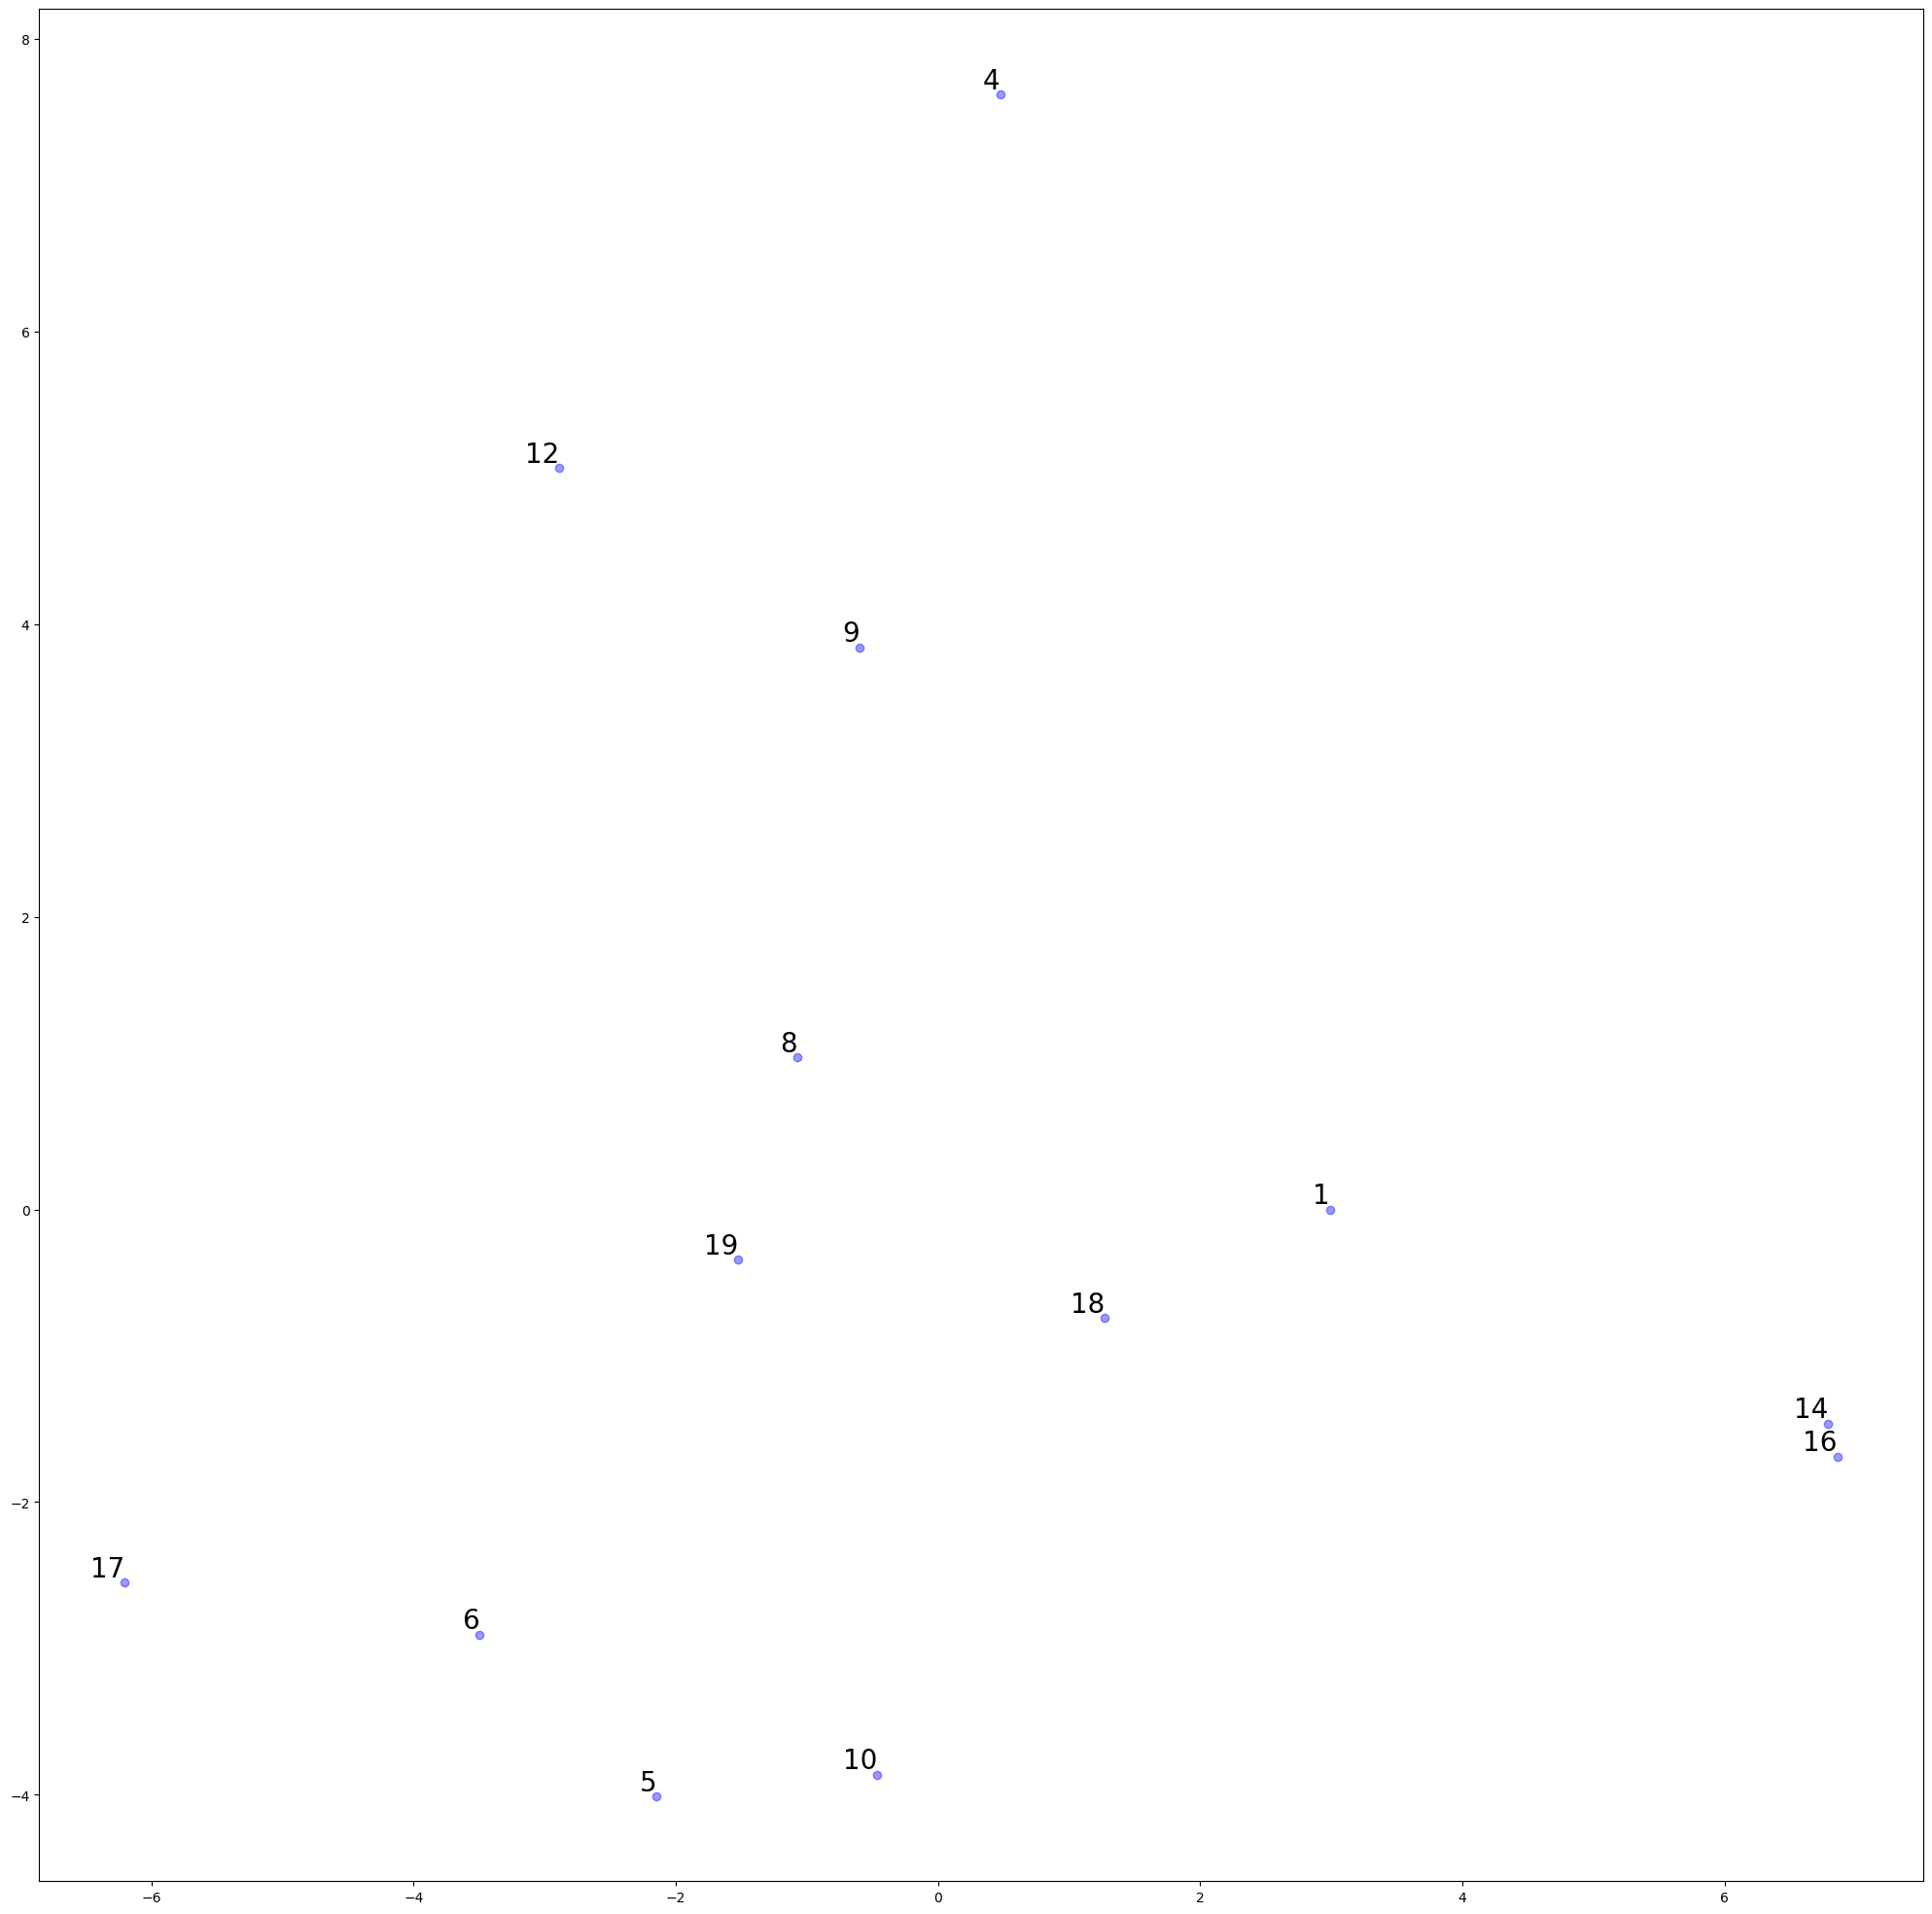

In [242]:
# see the 2D class segments embedding
class_PCA=PCA(n_components=2).fit_transform(EMBEDDINGS)
class_umap=umap.UMAP().fit_transform(EMBEDDINGS)
cluster_number=6
kmeans_best = SpectralClustering(n_clusters=cluster_number).fit_predict(class_PCA)
EMBEDDINGS_np=np.array(EMBEDDINGS)
plt.figure(figsize = (25,25))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(class_PCA[i][0], class_PCA[i][1],color='blue',alpha=0.4)
    plt.annotate(index_to_word[i], xy = (class_PCA[i][0], class_PCA[i][1]), \
        ha='right',va='bottom',fontsize=20)
plt.savefig(output_path+'/'+'w2v1.png')
#color=plt.cm.RdYlBu(kmeans_best[i]/3)
plt.show()

In [243]:

#word_to_cluster={}
#for i in range(cluster_number):
#    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#print(word_to_cluster)

##using the histogram method to cluster 



#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

# Show Filament Embedding and cluster

In [244]:
# average filament embedding
from scipy import stats
filament_cluster_number=2
average_method=0 # 0 is average, 1 is weight average
filament_score=[]
all_filament_data=[]
filament_variance=[]
for filament in corpus_ignore:
    score=torch.zeros(embedding_size)
    counts=0
    filament_list=[]
    for i in filament:
        if i==0:
            continue
        counts+=1
        filament_list.append(EMBEDDINGS[word_to_index[i]])
    if len(filament_list)==0:
        print('no')
    filament_list=np.array(filament_list)
    if len(filament_list)==1:
        filament_variance.append(float(0))
    else:
        pca=PCA(n_components=1).fit(filament_list)
        filament_variance.append(pca.singular_values_[0])
    mean=filament_list.mean(axis=0)
    all_filament_data.append(filament_list)
    if average_method==0:
        filament_score.append(mean)
    elif average_method==1:
        dim=len(filament_list[0])
        filament_normalized=np.exp(-0.5*((filament_list-mean) @ (filament_list-mean).T*0)).diagonal()/np.sqrt(np.pi**dim*0.05)
        filament_normalized=filament_normalized/filament_normalized.sum()
        score=filament_normalized @ filament_list
        if counts<=2:
            continue
        filament_score.append(np.array(score))
all_data=filament_score[:]
all_data.extend(EMBEDDINGS_np)
filament_number=len(filament_score)
print(filament_number)
#filament_normalized=np.exp(-0.5*((filament_list-mean) @ (filament_list-mean).T)).diagonal()/np.sqrt(np.pi**dim)

100


In [245]:
plt.hist(filament_variance)

(array([42.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 48.]),
 array([49.539337, 51.613335, 53.687332, 55.761333, 57.83533 , 59.90933 ,
        61.983326, 64.05733 , 66.131325, 68.20532 , 70.27932 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

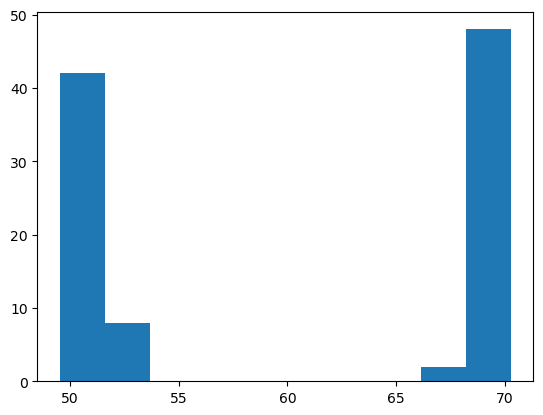

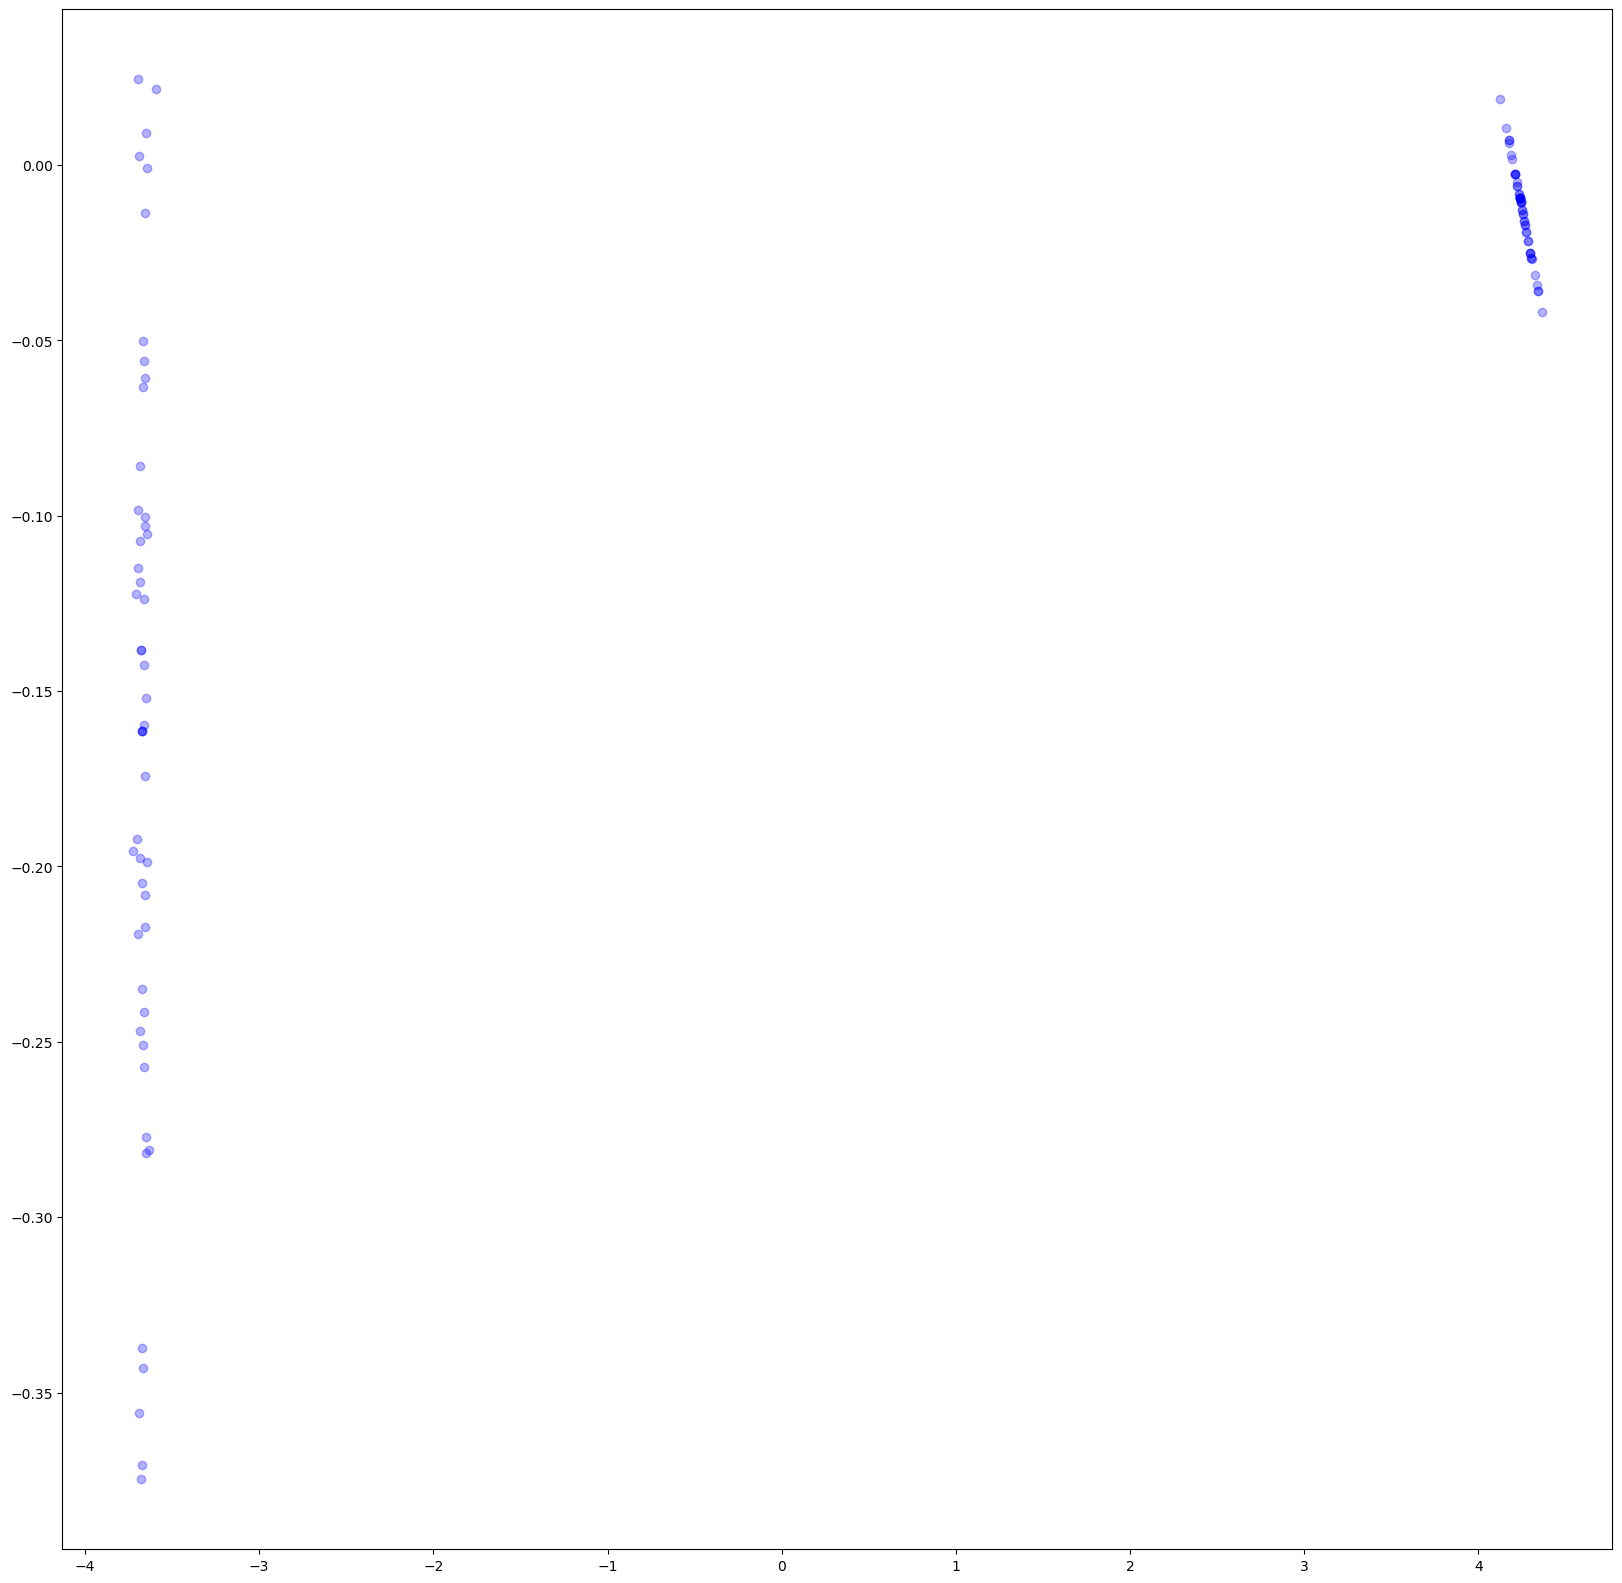

In [246]:
pca_sum = PCA(n_components=2).fit_transform(all_data)
pca_sum_3D = PCA(n_components=3).fit_transform(all_data)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:filament_number,0], pca_sum[:filament_number,1],alpha=0.3,color='blue')
#for i in range(len(EMBEDDINGS_np)):
#    plt.scatter(pca_sum[i+filament_number][0], pca_sum[i+filament_number][1],color='black',marker='*')
#    plt.annotate(index_to_word[i], xy = (pca_sum[i+filament_number][0], pca_sum[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

## Umap of the filament embedding

In [260]:
n_neighbors=100
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(all_data)
umap_3D = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=3).fit_transform(all_data)
filament_umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=50).fit_transform(all_data)[0:filament_number]
filament_umap=umap_2D[0:filament_number]
filament_umap_3D=umap_3D[0:filament_number]


2
3
4
5
6
7
8
9
10


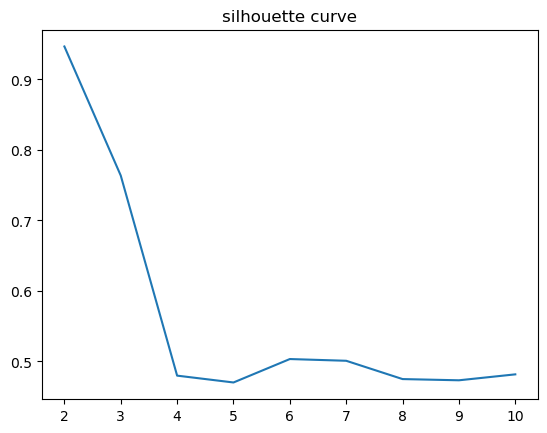

In [261]:
res=[]
n_cluster = range(2,11)
for i in n_cluster:
    print(i)
    kmeans_model = KMeans(n_clusters=i).fit(filament_umap)
    labels = kmeans_model.labels_
    a=metrics.silhouette_score(filament_umap, labels, metric='euclidean')
    res.append(a)

plt.plot(n_cluster, res)
plt.title('silhouette curve')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_silhouette.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

1


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


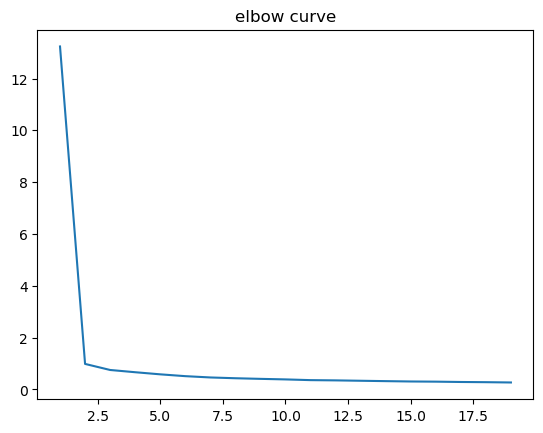

In [262]:
res = []
n_cluster = range(1,20)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(filament_umap_3D)
    res.append(np.average(np.min(cdist(filament_umap_3D, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

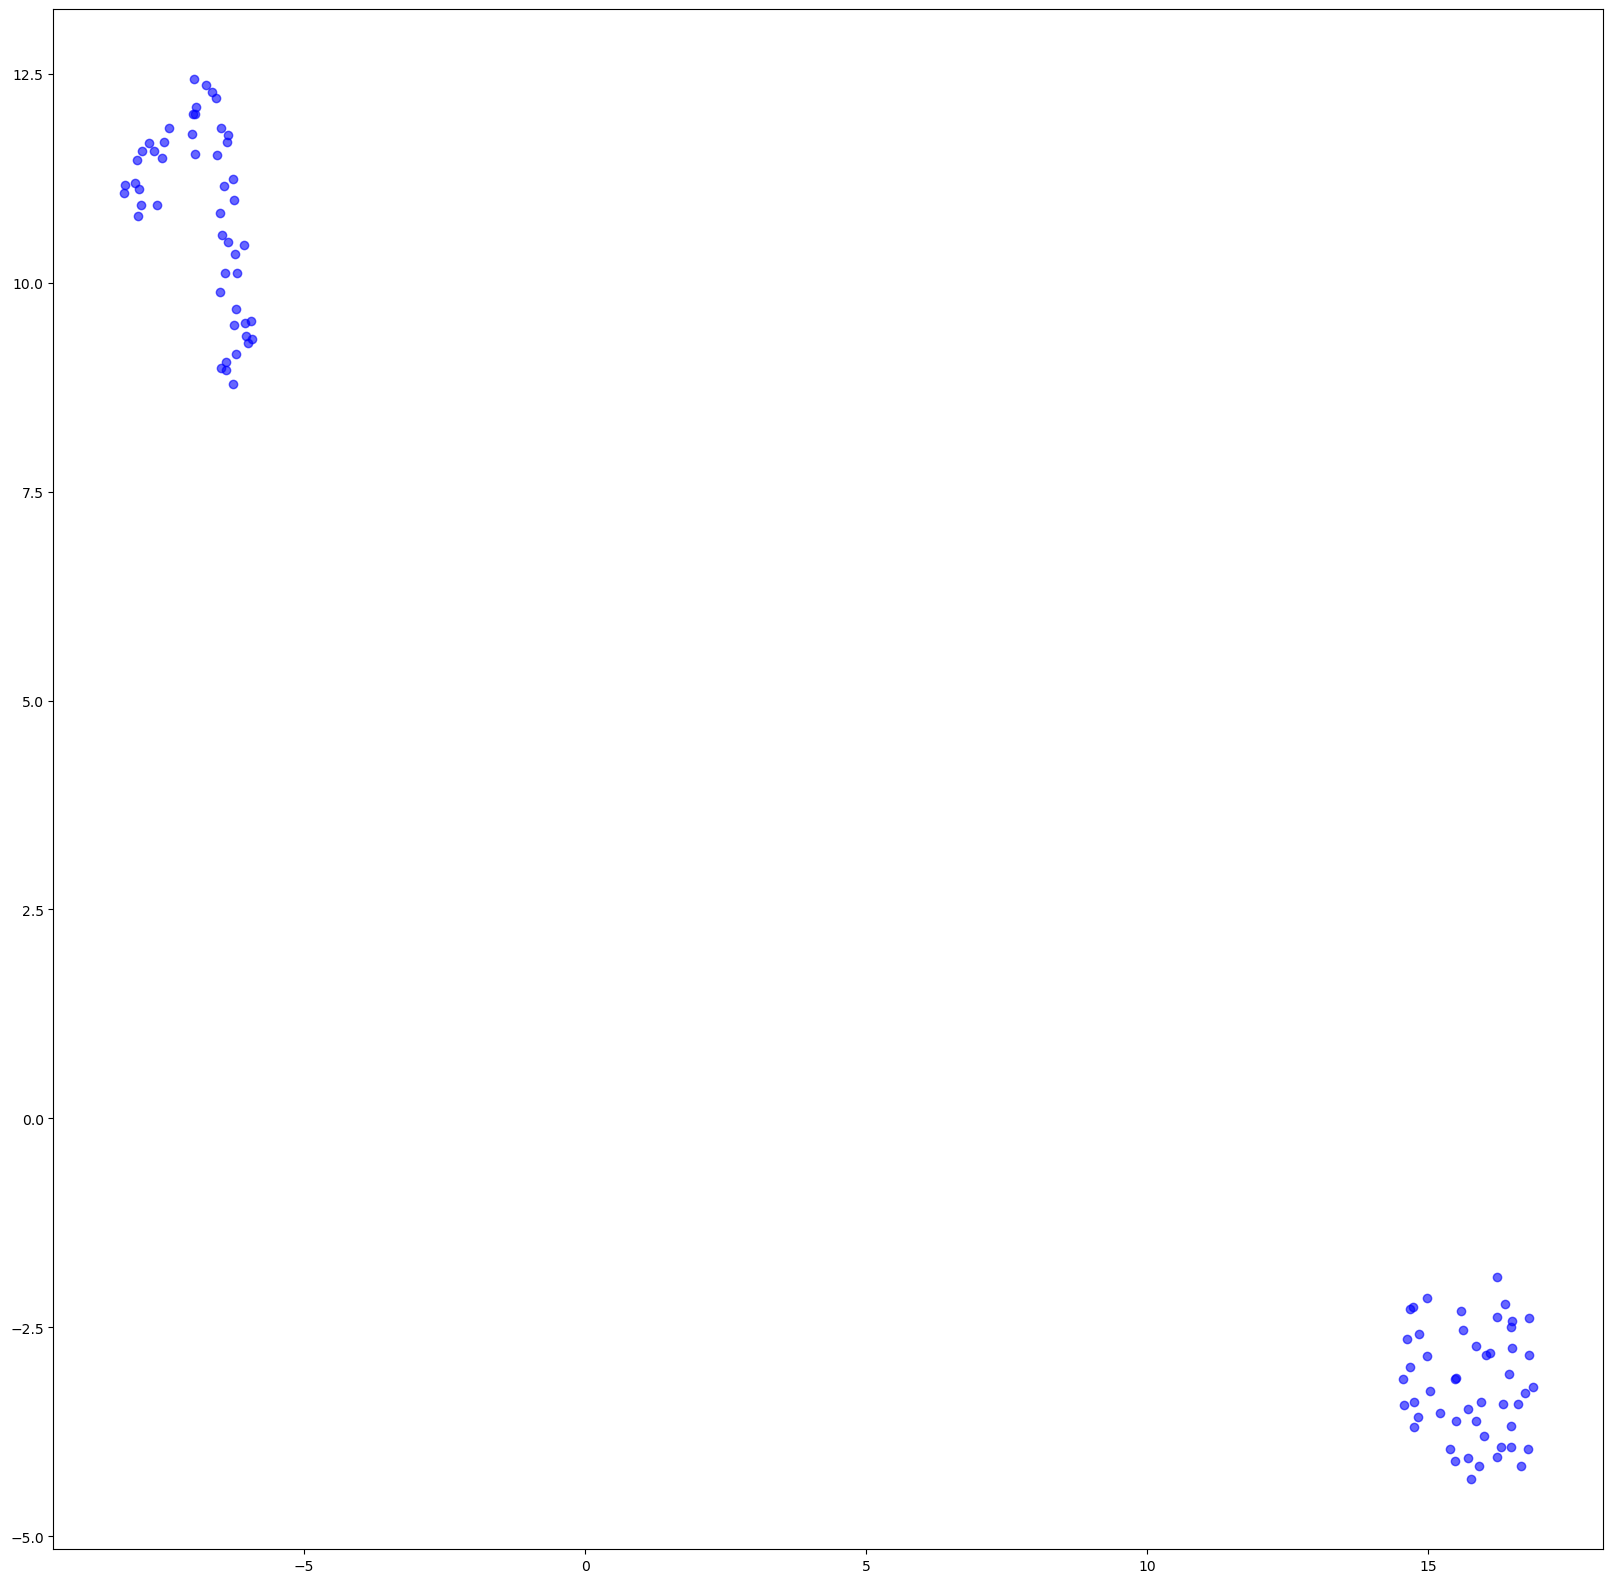

In [263]:
plt.figure(figsize = (20, 20))
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color='blue')
#plt.xlim([0,20])
#plt.ylim([-5,20])
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [264]:
with open(output_path+'/'+'umap_3D_normal.npy', 'wb') as f:
    np.save(f, filament_umap_3D)
print('finish umap')

finish umap


In [265]:
filament_cluster_number=3
umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(filament_umap_3D)
#umap_predict=SpectralClustering(n_clusters=filament_cluster_number).fit_predict(filament_umap)
#umap_predict=DBSCAN(eps=1.4, min_samples=300).fit_predict(filament_umap)+1
#filament_cluster_number=len(np.unique(umap_predict))
#np.save(output_path+'/'+'umap_predict.npy',umap_predict)

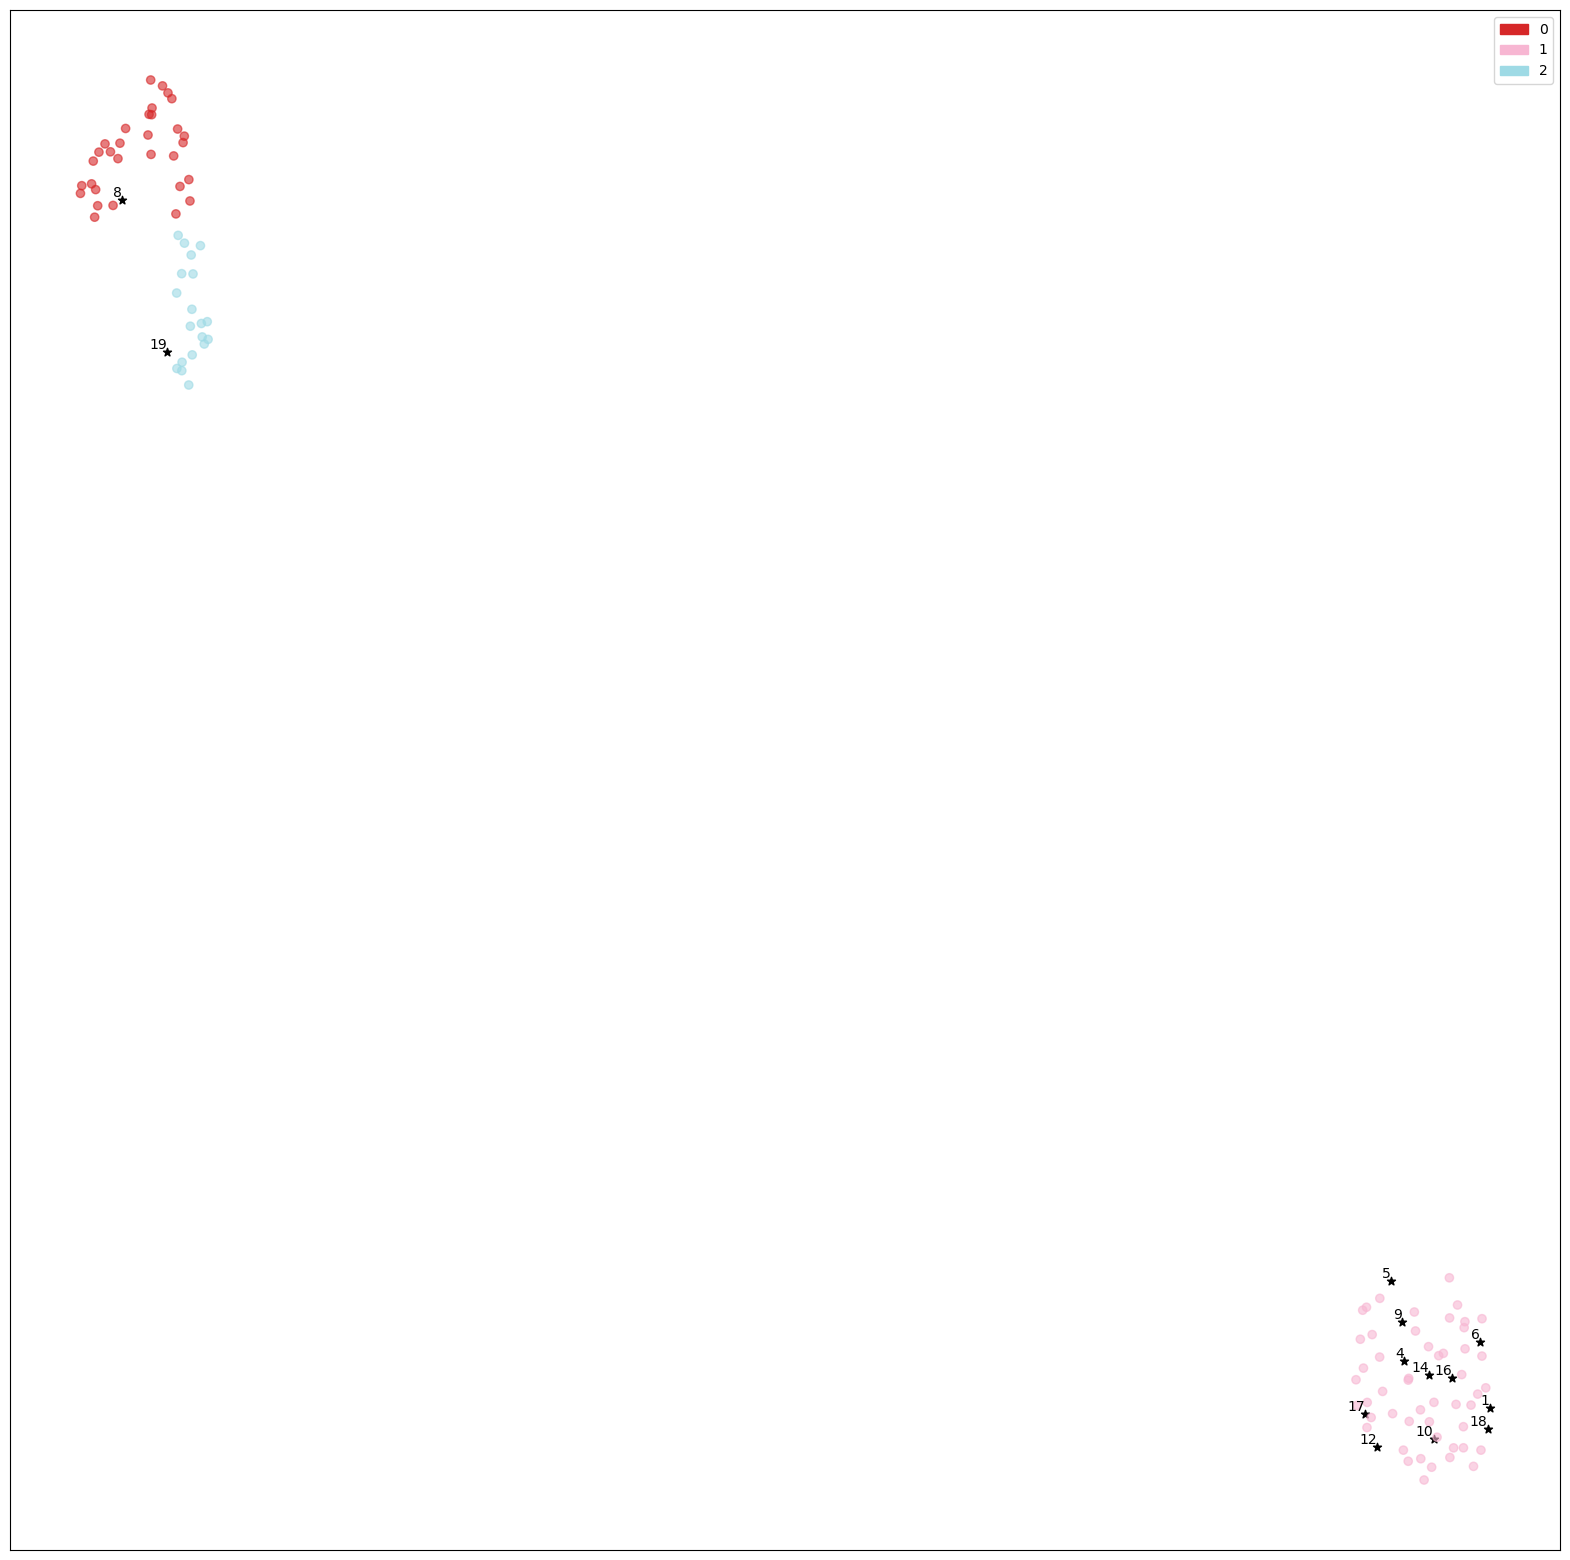

In [266]:
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), label=str(i))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
plt.tick_params(axis='both',which='both',bottom=False, left=False,labelbottom=False,labelleft=False) 
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*')
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
#color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

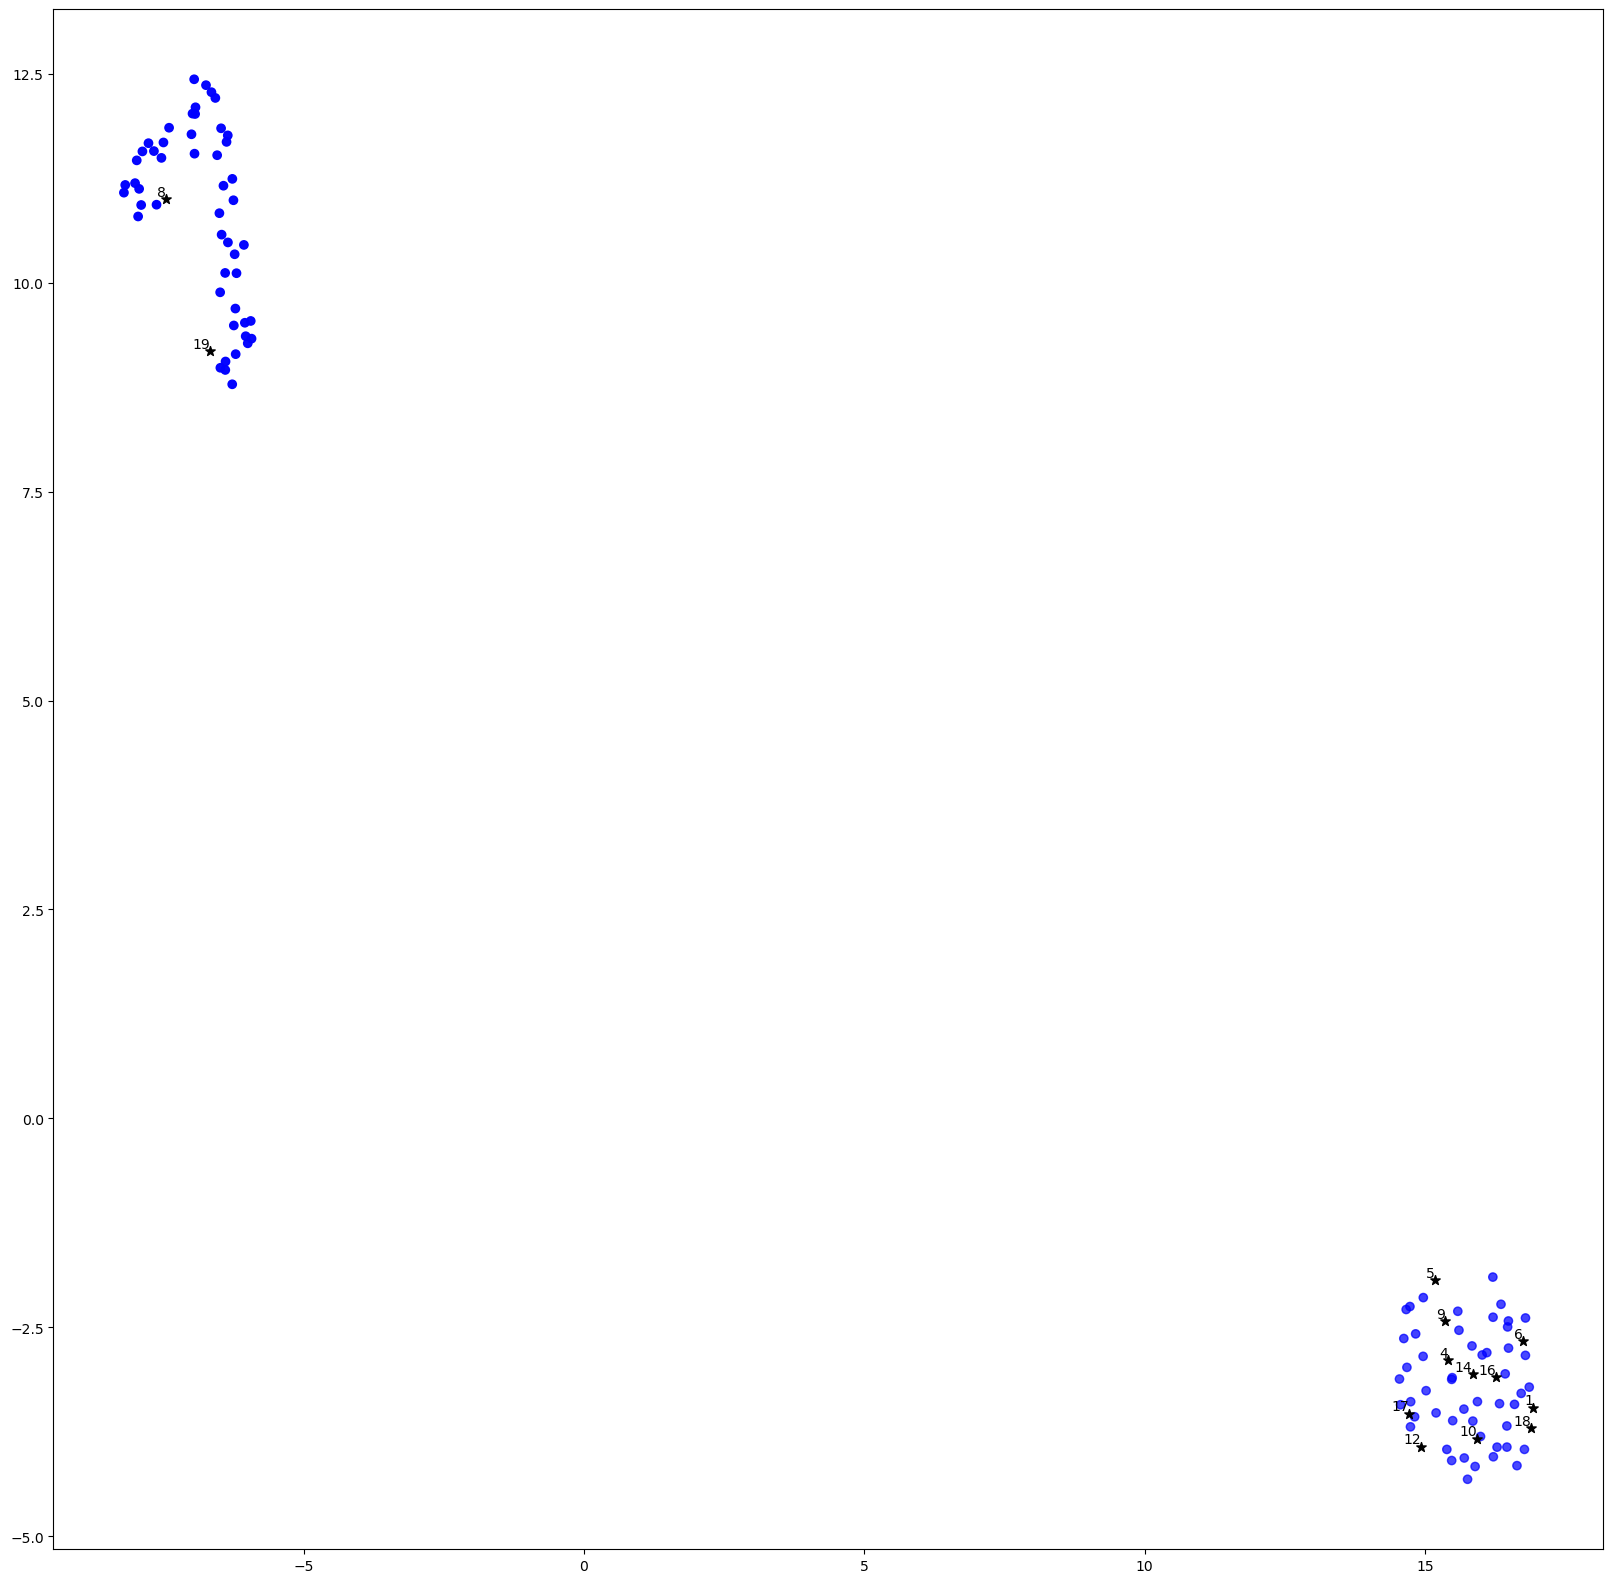

In [267]:
max_c=max(filament_variance)
filament_variance=np.array(filament_variance)
alpha=filament_variance/max_c
alpha_threshold=np.array([0 if a_ <0.1 else a_ for a_ in alpha])
rgba_colors = np.zeros((len(filament_variance),4))
rgba_colors[:,2]=1
rgba_colors[:,3]=alpha_threshold
plt.figure(figsize = (20, 20))
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=rgba_colors)
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue_threshold.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue_threshold.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

# color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)
# color='blue'

In [268]:
def select_area(all_filament_data,all_data_array,filament_index,start,length):
    select_filament_area=all_filament_data[filament_index][start:start+length]
    select_area_mean=select_filament_area.mean(axis=0)
    distance=np.sqrt(np.sum((all_data_array-select_area_mean)**2,axis=1))
    i=np.argmin(distance)
    return i, distance
similar_list=[]
filament_index=11
print(corpus_ignore[filament_index])
for i in range(0,len(all_filament_data[filament_index]),12):
    a, distance=select_area(all_filament_data,filament_score,filament_index,i,7)
    similar_list.append(a)
print(similar_list)

[5, 5, 5, 5, 5, 5, 9, 5, 12, 12, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 10, 10, 1, 1, 1, 1, 1, 1, 6, 6, 6, 17, 17, 17, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 1, 1, 1, 17, 18, 18, 18, 10, 10, 10, 10, 10, 1, 1, 1, 17, 17, 17, 17, 10, 10, 10, 10, 10, 10, 5, 5, 5, 14, 14, 14, 14, 14, 17, 17, 17, 17, 17, 17, 17, 17, 16, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 5, 5, 5, 5, 5]
[42, 42, 42, 26, 37, 17, 17, 17, 43, 3, 42]


## Seperate the clusters

In [269]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=umap_predict
positive_label=[]
for i in range(len(helix_name)):
    #positive_label.append(helix_name[i][11:14])
    #simulate experiment
    #positive_label.append(helix_name[i][63:68])
    positive_label.append(helix_name[i].split('-')[-2][-10:])
positive_label=np.array(positive_label)
labels=list(np.unique(positive_label))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
#labels_name=['type 3','type 1B','type 2B','type 1A','type 2A','type 2AB'] # define the type of filaments 
#labels_name=['singlet','doublet']
#labels_name=['jagged','snake','twister']
#labels_name=['PHF','SF']
labels_name=['SF','PHF']
clustersize=[]
for i in range(filament_cluster_number):
    clustersize.append(len(locals()['cluster'+str(i)]))
print(labels)
print(clustersize)
print(helix_name[i].split('-'))

['type1.mrcs', 'type2.mrcs']
[0, 0, 0]
['Noise/NoNoise_same_ori/type1.mrcs', '3']


# Compare with the positive labels

100 100
100


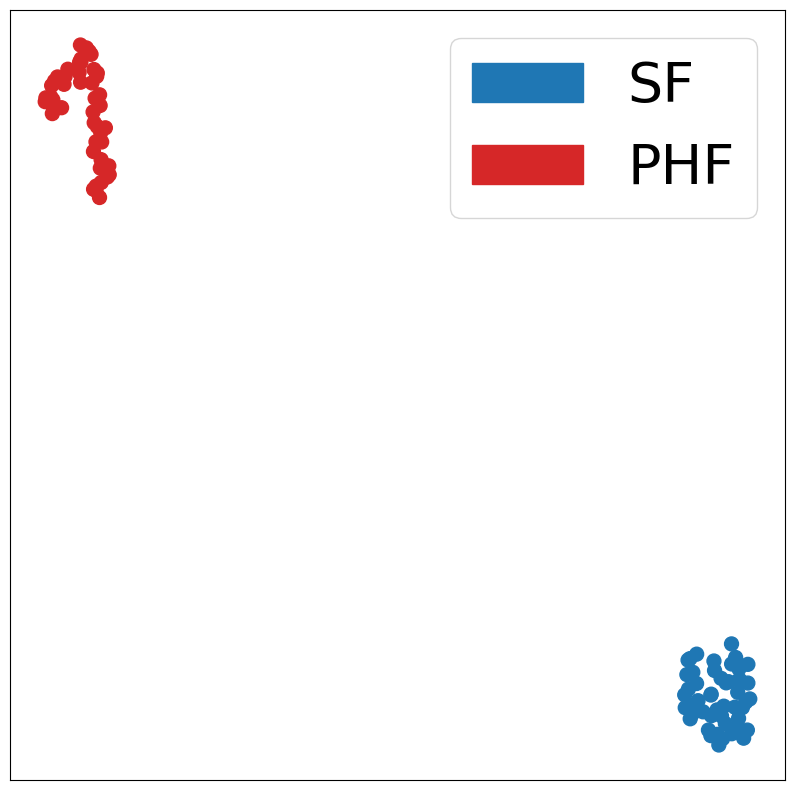

In [270]:
print(len(positive_label_new),len(filament_umap))
plt.figure(figsize = (10, 10))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/3), label=labels_name[i])
plt.tick_params(axis='both',which='both',bottom=False, left=False,labelbottom=False,labelleft=False) 
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))],fontsize=40)
print(len(positive_label))
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=plt.cm.tab20(positive_label_new/3),s=100)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_label.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_label.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

31 0
50 1
19 2
[[0.0, 1.0], [1.0, 0.0], [0.0, 1.0]]


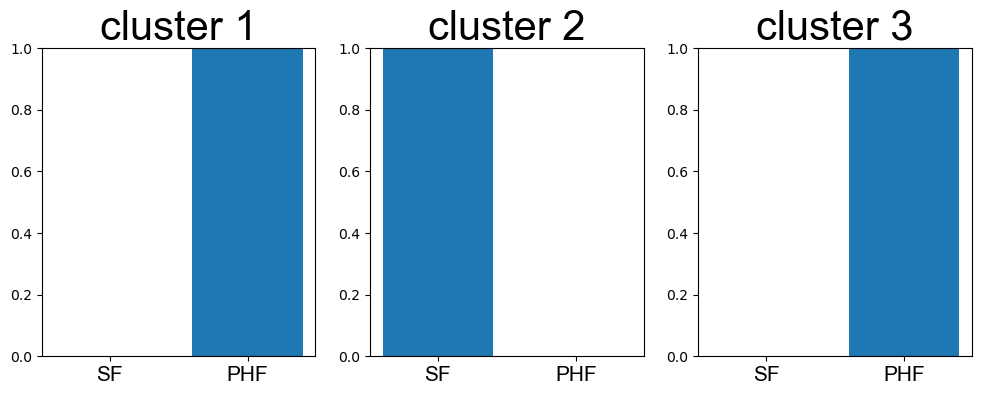

In [271]:
# histogram on rate of successful
import pandas as pd
hist_data=pd.DataFrame({'labels':positive_label_new,'predict':cluster_choice})
distribution_hist_all=[]
particle_number=[]
for i in range(filament_cluster_number):
    distribution=[]
    lst=hist_data[hist_data['predict']==i]
    particle_number.append(len(lst))
    print(len(lst),i)
    for j in range(len(labels)):
        distribution.append(len(lst[lst['labels']==j])/len(lst))
    distribution_hist_all.append(distribution)
print(distribution_hist_all)
np.save(output_path+'/''class_distribution.npy',distribution_hist_all)
np.save(output_path+'/''particle_number.npy',particle_number)
fig, ax = plt.subplots(1,filament_cluster_number,figsize = (4*filament_cluster_number,4))

for i in range(filament_cluster_number):
    ax[i].bar(range(len(labels)),distribution_hist_all[i],tick_label =labels_name)
    ax[i].set_ylim(bottom=0, top=1)
    ax[i].set_xticklabels(labels_name, fontsize=15, fontname='Arial')
    ax[i].set_title('cluster {}'.format(i+1),fontsize=30, fontname='Arial')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.pdf',bbox_inches='tight', pad_inches=0.1)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

100 100
[  0. 180. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0.   0.   0.
 180. 180. 180.   0.   0.   0.   0. 180.   0. 180. 180. 180. 180.   0.
   0. 180. 180.   0.   0. 180. 180. 180.   0. 180. 180.   0. 180. 180.
 180. 180. 180.   0.   0.   0. 180.   0.   0.   0.   0. 180. 180.   0.
 180. 180. 180. 180.   0.   0.   0. 180.   0.   0. 180. 180.   0. 180.
 180. 180. 180. 180. 180.   0. 180. 180. 180. 180. 180.   0. 180. 180.
 180.   0. 180.   0.   0.   0.   0.   0. 180.   0.   0.   0. 180.   0.
 180. 180.]
2


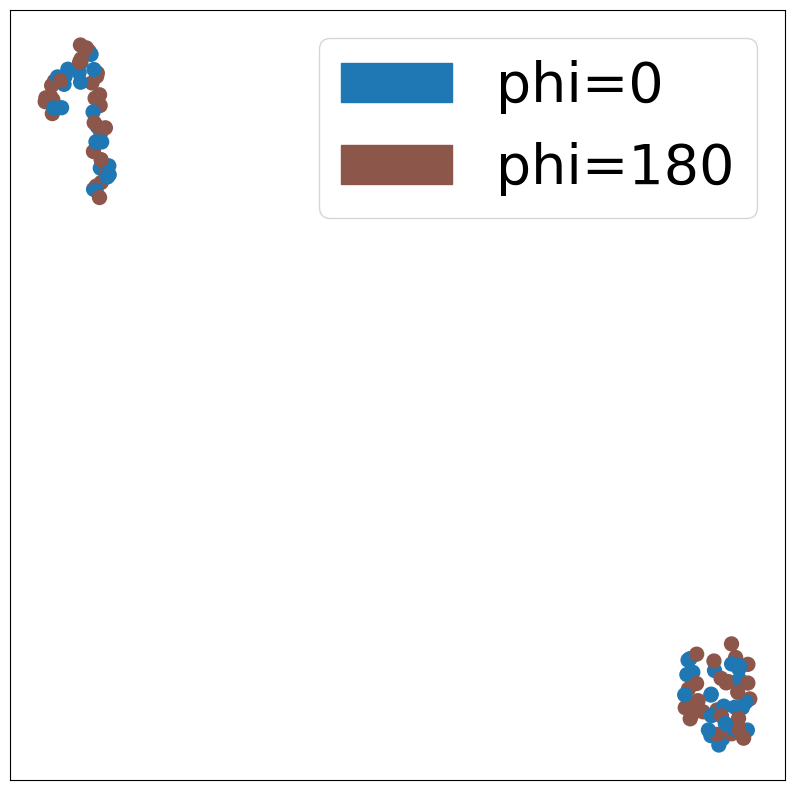

In [272]:
print(len(positive_label_new),len(filament_umap))
ori_type1=np.load('F:/script/class2vec/real_star_file/simulation/NoNoise_random/type1_filament_polarity.npy')
ori_type2=np.load('F:/script/class2vec/real_star_file/simulation/NoNoise_random/type2_filament_polarity.npy')
polarity_label=[0,180]
polarity=np.append(ori_type1,ori_type2)
print(polarity)
plt.figure(figsize = (10, 10))
for i in range(len(polarity_label)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/2), label='phi='+str(polarity_label[i]))
plt.tick_params(axis='both',which='both',bottom=False, left=False,labelbottom=False,labelleft=False) 
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(polarity_label))],fontsize=40)
print(len(polarity_label))
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=plt.cm.tab20(polarity/360),s=100)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_ori.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_ori.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [59]:
#seperate cluster
for i in range(filament_cluster_number):
    locals()['cluster'+str(i)]=[]
    locals()['clusterID'+str(i)]=[]
for i in range(len(corpus)):
    labels=umap_predict[i]
    locals()['clusterID'+str(labels)].append(i)
    lst=corpus[i]
    for j in range(len(lst)):
        dataline=lst[j][-1]
        locals()['cluster'+str(labels)].append(data[dataline])

In [ ]:
#seperarte subcluster
for i in range(filament_cluster_number):
    cluster=locals()['cluster'+str(i)]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        subcluster_name='cluster'+str(i)+'_'+str(j)
        locals()[subcluster_name]=[x for x, y in zip(cluster,lst) if y==labels[j]]

In [ ]:
print(helix_name[0])

# Write .star file for the clusters

In [60]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
# write subcluster relion
for i in range(filament_cluster_number):
    for j in range(filament_cluster_number):
        cluster_name='cluster'+str(i)+'_'+str(j)
        data_cluster=locals()[cluster_name]
        if datatype==0:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.opticgroup(optics)
            output.writecluster()
        elif datatype==1:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.writemetadata()
            output.writecluster()